In [1]:
import torch
import numpy as np

import ast
%load_ext autoreload
%autoreload 2

In [2]:
# import sys
# sys.version

In [3]:
import model
import train

In [4]:
import ast
import os

from collections import Counter, defaultdict

In [5]:
def fails(func):
    try:
        func()
        return False
    except:
        return True

In [6]:
def read_all(path = "../CodeStylometry/Corpus/temp/codejamfolder/py"):
    result = {}
    for handle in os.listdir(path):
        handle_path = os.path.join(path, handle)
        result_for_handle = defaultdict(str)
#         for contest in os.listdir(handle_path):
#             contest_path = os.path.join(handle_path, contest)
        for solution in os.listdir(handle_path):
                solution_path = os.path.join(handle_path, solution)
                with open(solution_path, "r") as f:
                    try:
                        result_for_handle[solution] = f.read()
                    except Exception as e:
                        print(solution_path)
                        print(e)
                    
        result[handle] = result_for_handle
        
    return result

In [7]:


def filter_by_count(data, min_count, max_count):
    result = {}
    for handle, result_for_handle in data.items():
        current = {}
        for problem, solution in result_for_handle.items():
            if not fails(lambda: ast.parse(solution)):
                current[problem.split(".")[0]] = solution


        if len(current) >= min_count and len(current) <= max_count:
            result[handle] = current
    
    return result


In [8]:
data = read_all()

../CodeStylometry/Corpus/temp/codejamfolder/py/smartek0/p2463486.smartek0.py
'utf-8' codec can't decode byte 0xfc in position 111: invalid start byte
../CodeStylometry/Corpus/temp/codejamfolder/py/RedApe0/p1481486.RedApe0.py
'utf-8' codec can't decode byte 0xee in position 1204: invalid continuation byte
../CodeStylometry/Corpus/temp/codejamfolder/py/RedApe0/p1485488.RedApe0.py
'utf-8' codec can't decode byte 0xea in position 1289: invalid continuation byte
../CodeStylometry/Corpus/temp/codejamfolder/py/RedApe0/p1080487.RedApe0.py
'utf-8' codec can't decode byte 0xf2 in position 1158: invalid continuation byte
../CodeStylometry/Corpus/temp/codejamfolder/py/RedApe0/p1590487.RedApe0.py
'utf-8' codec can't decode byte 0xef in position 3183: invalid continuation byte
../CodeStylometry/Corpus/temp/codejamfolder/py/RedApe0/p1480487.RedApe0.py
'utf-8' codec can't decode byte 0xe3 in position 1306: invalid continuation byte
../CodeStylometry/Corpus/temp/codejamfolder/py/apinzonf0/p24481.apinzo

In [9]:
data = filter_by_count(data, 25, 100)

In [10]:
def filter_people(df, people):
    result = {}
    for handle, result_for_handle in df.items():
        if handle in people:
            result[handle] = result_for_handle
    
    return result

In [11]:
def filter_ast_size(df, mn=0, mx=500):
    result = {}
    for handle, result_for_handle in df.items():
        current_result = {}
        for problem, submission in result_for_handle.items():
            try:
                parsed = ast.parse(submission)
                length = len(list(ast.walk(parsed)))
                print(length)
                if length >= mn and length <= mx:
                    current_result[problem] = submission
            except:
                pass
            
        result[handle] = current_result
    
    return result

In [12]:
# data = filter_ast_size(data, mn=50, mx=4000)

In [13]:
print(sorted(data.keys()))

['EricStansifer0', 'Nin00', 'RalfKistner0', 'Sp30000', 'ali.assaf0', 'bigOnion0', 'd.operator0', 'damo.yu0', 'dareonion0', 'dennis.lissov0', 'killerrex0', 'mth0', 'pawko0', 'peter.gtz0', 'ronnodas0', 'royf0', 'shaunren0', 'takluyver0']


In [14]:
batch_sampler = train.StratifiedBatcherPreprocessedRandom(data, 64, 0.8)
# batch_sampler = train.NameBatcher(data, 64, train_problems, test_problems)

In [15]:
batch_sampler.classes

['EricStansifer0',
 'Nin00',
 'RalfKistner0',
 'Sp30000',
 'ali.assaf0',
 'bigOnion0',
 'd.operator0',
 'damo.yu0',
 'dareonion0',
 'dennis.lissov0',
 'killerrex0',
 'mth0',
 'pawko0',
 'peter.gtz0',
 'ronnodas0',
 'royf0',
 'shaunren0',
 'takluyver0']

In [16]:
batch_sampler.get_n_classes()

18

In [17]:
np.unique(batch_sampler.y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([21, 22, 20, 24, 37, 33, 28, 30, 20, 34, 24, 31, 32, 20, 26, 24, 20,
        20]))

In [18]:
np.unique(batch_sampler.y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 6,  6,  5,  6, 10,  9,  7,  8,  5,  9,  6,  8,  8,  5,  7,  6,  6,
         5]))

In [19]:
cls = model.Model(batch_sampler.get_n_classes(), embedding_dims=100)

In [20]:
# trainer = train.Trainer(cls, torch.nn.CrossEntropyLoss(), torch.optim.SGD(cls.parameters(), lr=0.01, momentum=0.9))
trainer = train.Trainer(cls, torch.nn.CrossEntropyLoss(), torch.optim.Adam(cls.parameters()))

In [21]:
# %ls

In [22]:
torch.set_num_threads(1)

In [23]:
# cls.preprocessed = False

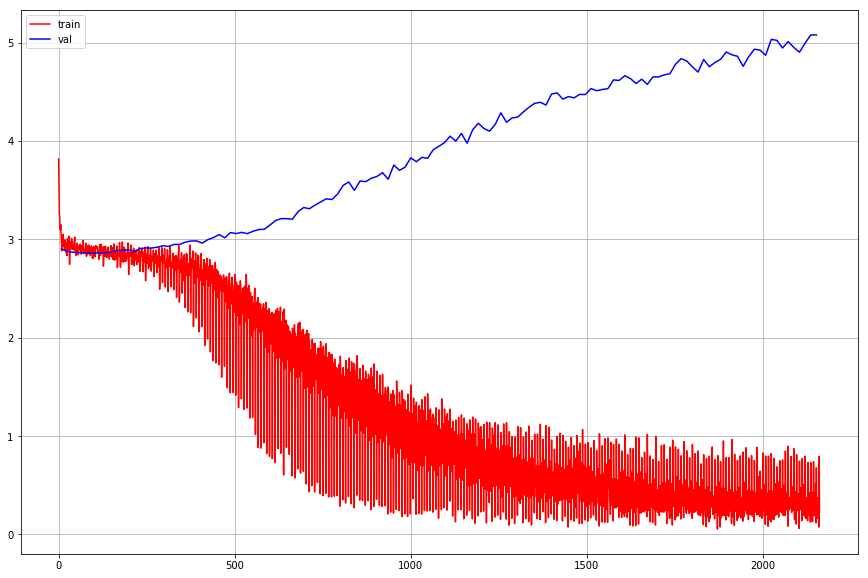

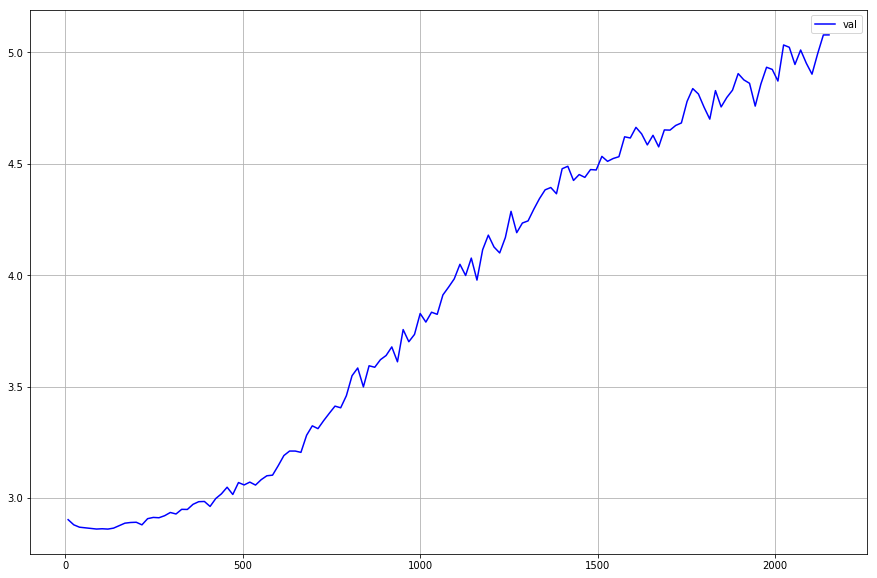

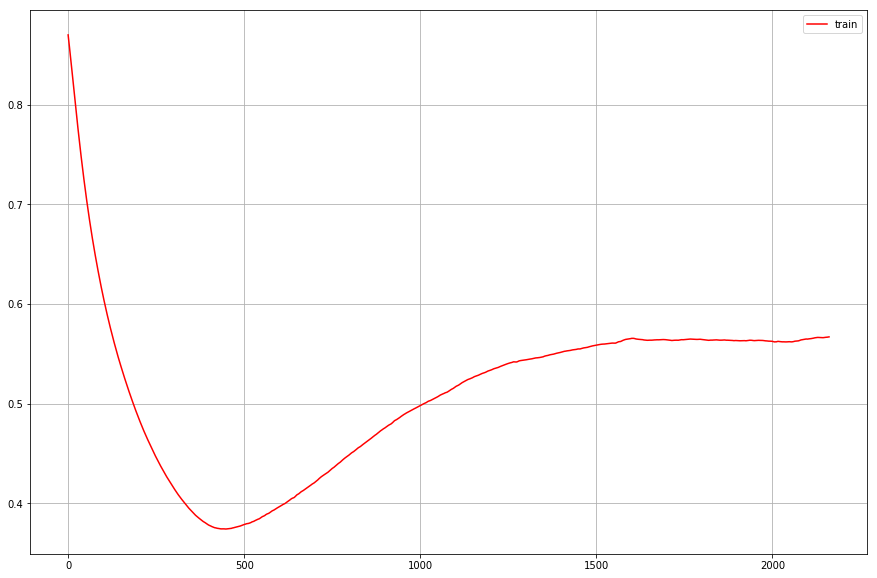

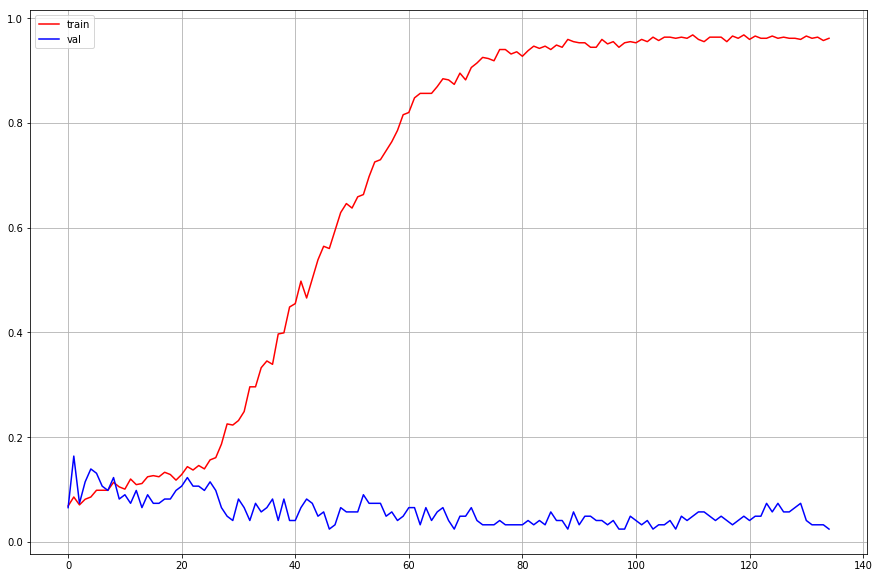

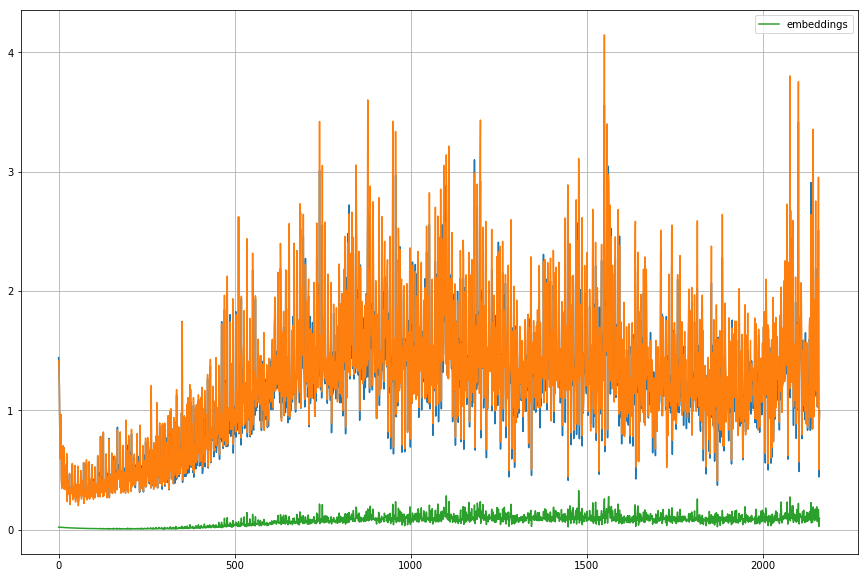

KeyboardInterrupt: 

In [24]:
trainer.train(batch_sampler, {"n_epochs":800})

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
def build_confusion_matrix(predicted_probs, true):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
    
#     print(pred)
#     print(true)
#     print(len(true))
    
    accuracy = np.count_nonzero(pred == true.ravel())/len(true)
    print("Accuracy = ", accuracy)
#     true = true_y.argmax(axis=1)
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
    norm = result.sum(axis=1)
    norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result

def plot_confusion_matrix(confusion_matrix):
    fig = plt.figure( figsize=(20, 20))
    plt.xlabel("True classes")
    plt.ylabel("Predicted classes")
#     sns.heatmap(confusion_matrix, annot=True, vmin=0.0, vmax=1.0, cmap="YlGnBu")
    sns.heatmap(confusion_matrix, annot=True, vmin=0.0, cmap="YlGnBu")

In [26]:
import gc
gc.collect()

12173

In [27]:
cls.eval()
x, y = batch_sampler.x_train, batch_sampler.y_train
pred = torch.nn.functional.softmax(cls.forward(x), dim=1)

Accuracy =  0.9570815450643777


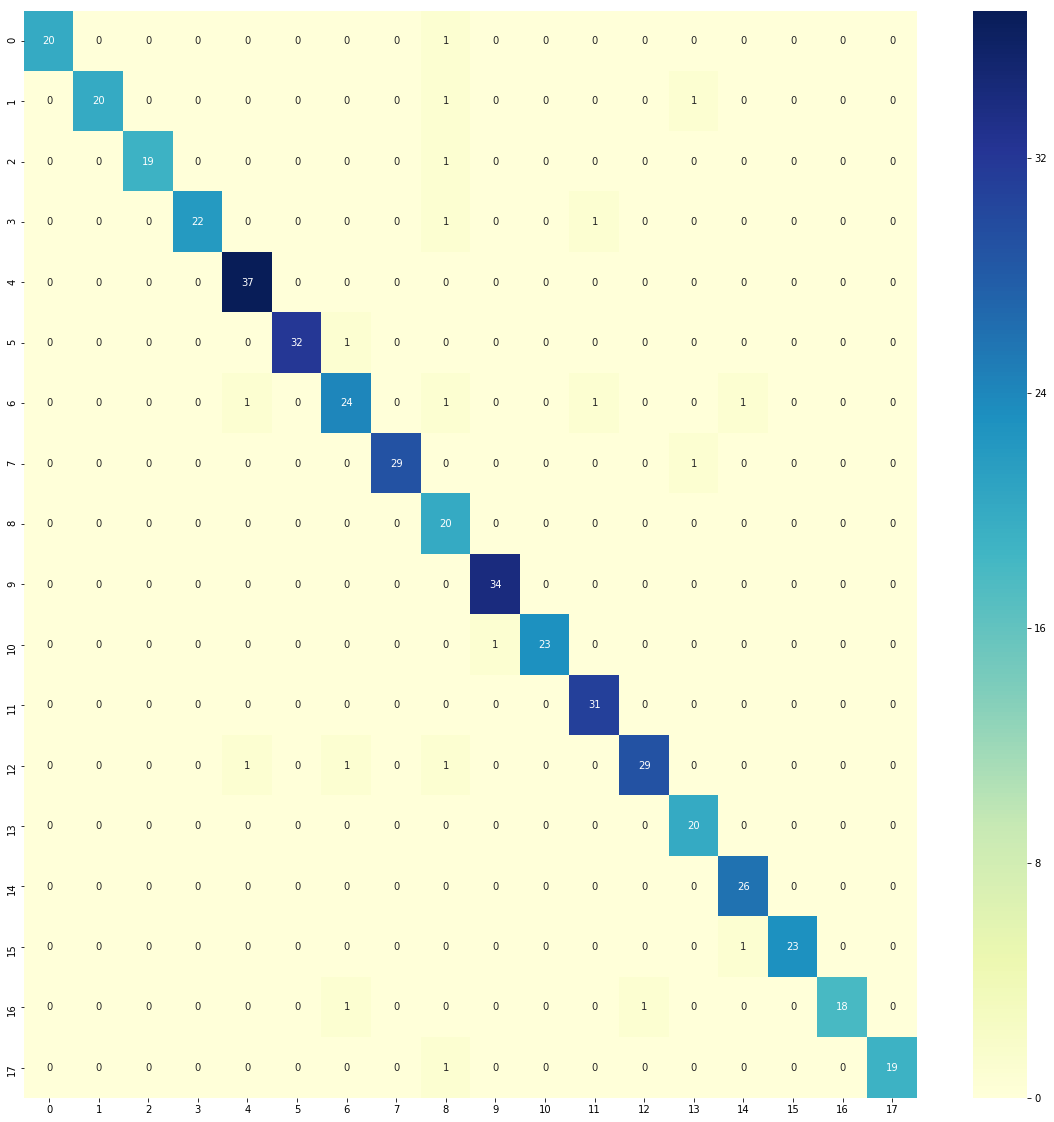

In [28]:
plot_confusion_matrix(build_confusion_matrix(pred.detach().numpy(), y.reshape(-1, 1)))

In [29]:
#cls.eval()
x, y = batch_sampler.x_test, batch_sampler.y_test
pred = torch.nn.functional.softmax(cls.forward(x), dim=1)

Accuracy =  0.03278688524590164


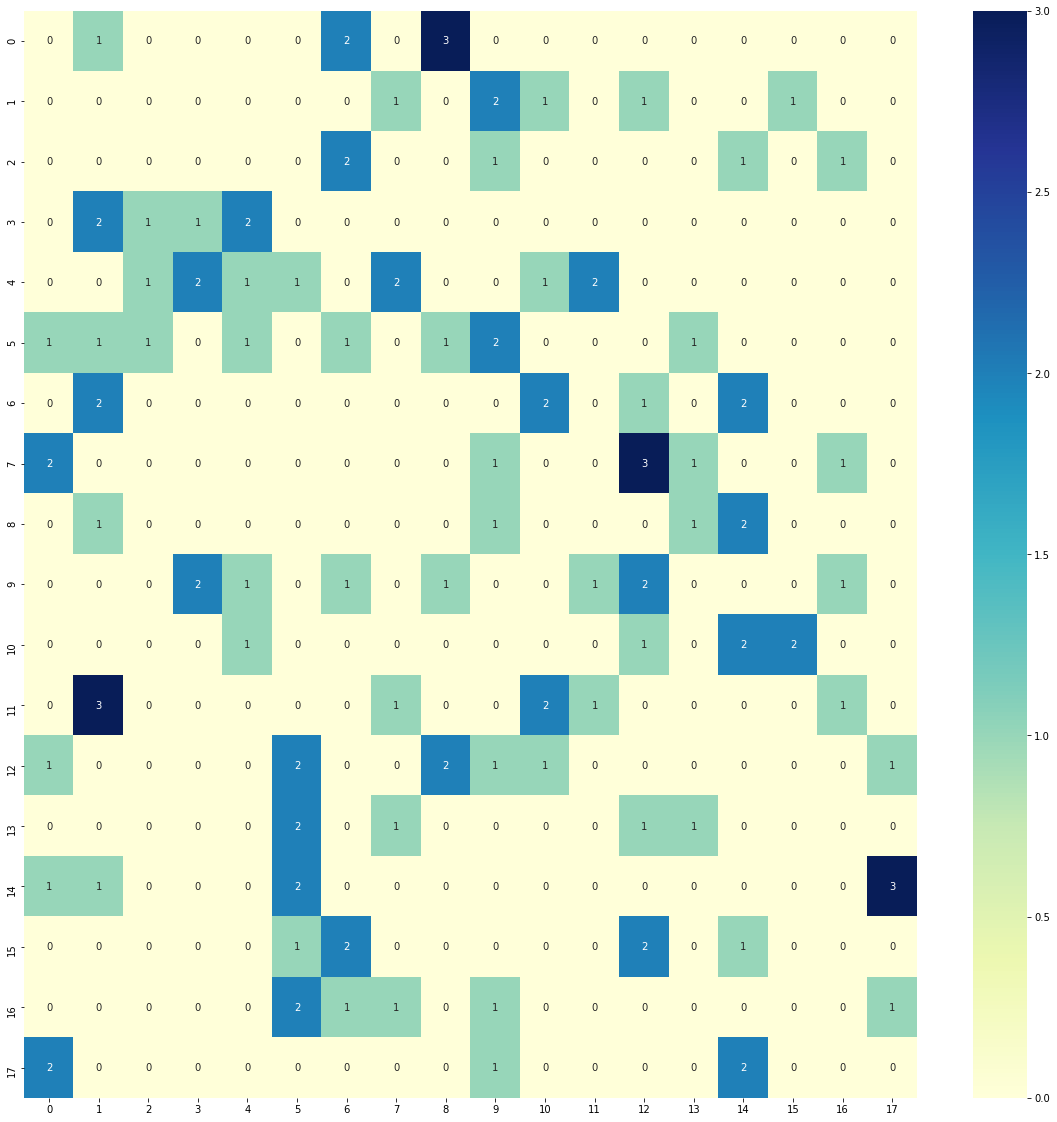

In [30]:
plot_confusion_matrix(build_confusion_matrix(pred.detach().numpy(), y.reshape(-1, 1)))

In [31]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm
n_classes = batch_sampler.get_n_classes()
# colors = {0:'r', 1:'g', 2:'b', 3:'c', 4:'y
colors = {i:c for i, c in enumerate(cm.rainbow(np.linspace(0, 1, n_classes)))}
pca = PCA(n_components=2)
x_transformed = cls.transform_batch(batch_sampler.x_train)
x_test_transformed = cls.transform_batch(batch_sampler.x_test)
pca.fit(x_transformed.detach())
def plot_pca(x, y, alpha=1.0):
    plt.figure(figsize=(20, 20))
    plt.scatter(x[:, 0], x[:, 1], color=list(map(colors.get, y)), alpha=alpha)
    plt.show()

<Figure size 1440x1440 with 0 Axes>

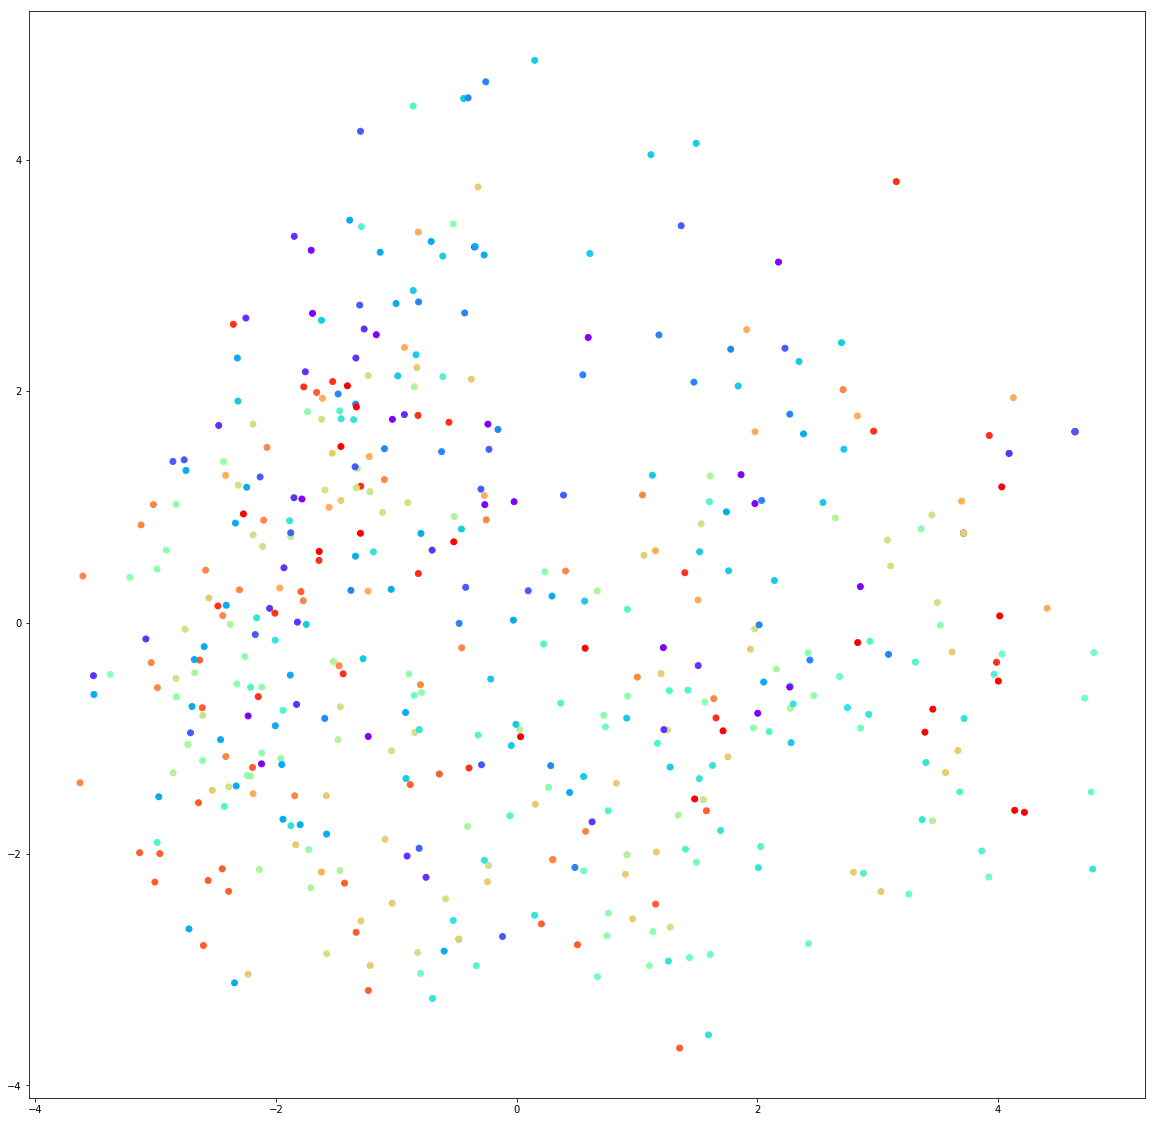

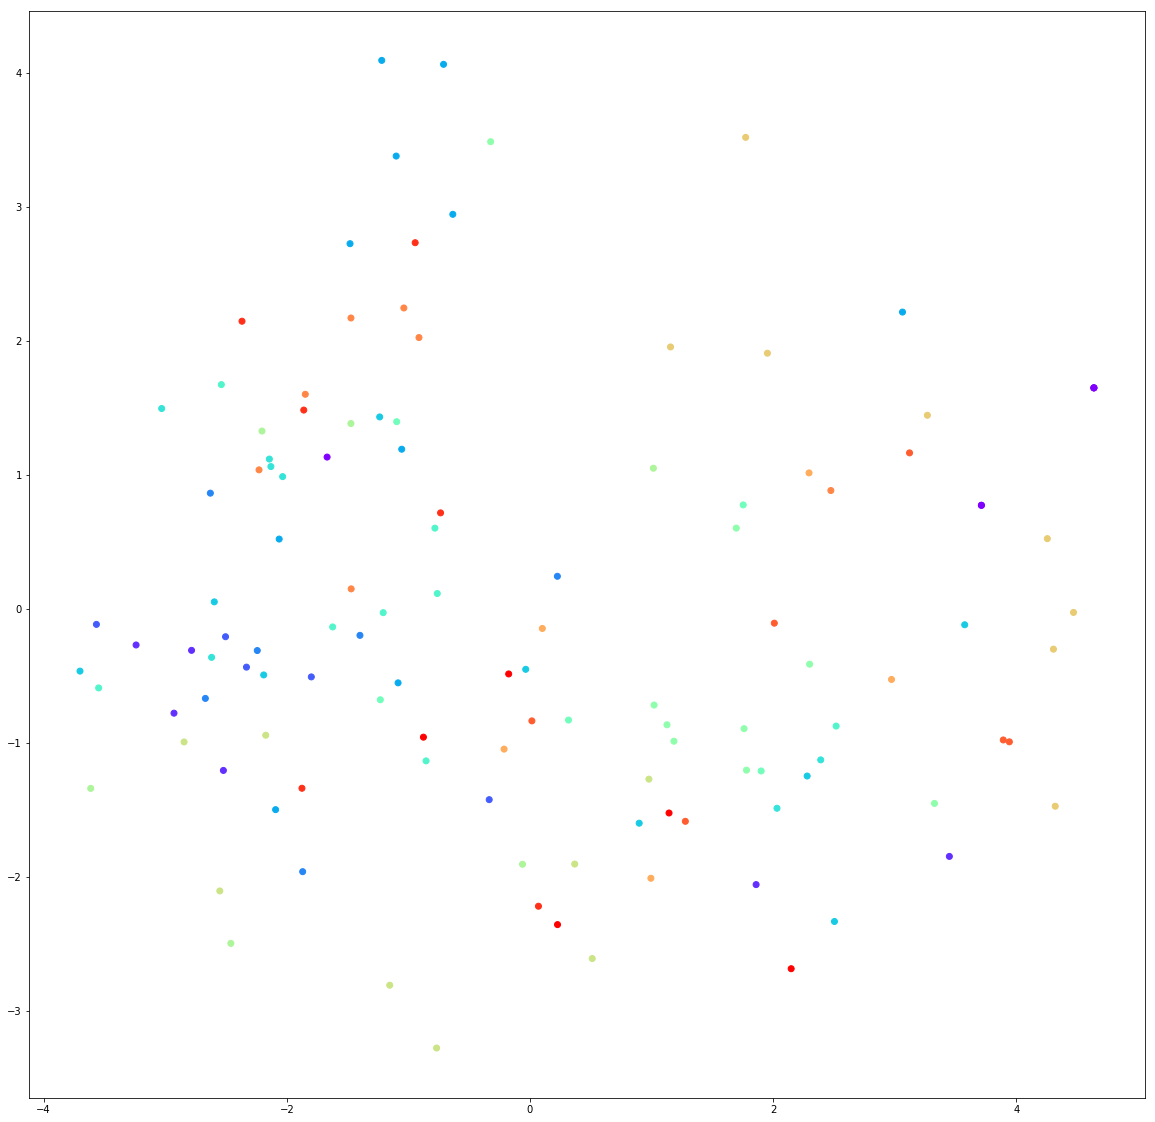

In [32]:
plt.figure(figsize=(20, 20))
plot_pca(pca.transform(x_transformed.detach()), batch_sampler.y_train, alpha=1.0)
plot_pca(pca.transform(x_test_transformed.detach()), batch_sampler.y_test, alpha=1.0)
# plt.show()